In [1]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.prediction_list`
"""

In [2]:
query_job3 = bigquery_client.query(query)
test_df = query_job3.to_dataframe()
#test_df["time"] = pd.datetime(2022-09-24, format = %Y%m%d)
test_df["day"] = 6
test_df["month"]=11

NameError: name 'bigquery_client' is not defined

In [3]:
test_df.drop_duplicates()

NameError: name 'test_df' is not defined

In [4]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n# The following code is used to help our research team understand how you \n# our notebook environment. We do not collect any personal information with\n# the following code, it is used to measure when and how often you work on\n# your submission files.\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

In [5]:
get_ipython().run_cell_magic('capture', '', "\n#- INSTALL ADDITIONAL LIBRARIES IF REQUIRED\n#------------------------------------------\n# This is normally not required. The hub environment comes preinstaled with \n# many packages that you can already use without setup. In case there is some\n# other library you would like to use that isn't on the list you run this command\n# once to install them.  If it is already installed this command has no effect.\n\n!python3 -m pip install pandas\n!pip install chardet\n!pip install db-dtypes\n!pip install catboost\n")

In [6]:
#Importing Libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
import pandas as pd
import csv
import numpy as np

In [8]:
from google.cloud import bigquery
import scipy as sp
import statsmodels as sm
import statistics as stat
import sklearn
import patsy as pt
import chardet as ch
import click as cl
import cytoolz as cz
import dask
import decorator as dr
#import pyjson5 as py
import jsonschema as js
import tables
import db_dtypes
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

ModuleNotFoundError: No module named 'chardet'

In [9]:
global df3

In [10]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [11]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.wage_data`
"""

In [12]:
query_job1 = bigquery_client.query(query)
query_job1

QueryJob<project=ironhacks-data, location=US, id=bf82cfa3-d93f-49c8-a023-5e79f685fd34>

In [13]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data`
"""

In [14]:
query_job2 = bigquery_client.query(query)
query_job2

QueryJob<project=ironhacks-data, location=US, id=e3bbf36d-e3a5-4962-a8ea-03b01e70d379>

In [15]:
!pip install db-dtypes
df1 = query_job2.to_dataframe()
df1.uu_id.nunique()

525

In [16]:
!pip install db-dtypes
df2 = query_job1.to_dataframe()
df2.uu_id.nunique()

525

In [17]:
df3 = pd.merge(df1,df2, on= ["uu_id","countyfips","tract","tract_name"])

In [18]:
#Expanding timeperiod to day, month and year
df3["time"] = pd.to_datetime(df3["timeperiod"], format= '%Y%m%d', errors = "coerce")
df3 =df3.drop("timeperiod", axis = 1)
df3["month"] = df3["time"].dt.month
df3["day"] = df3["time"].dt.day
str_col = ["tract_name", 'top_category_employer1', 'top_category_employer2',
       'top_category_employer3',"time"]
df3["uu_id_enc"] = df3["uu_id"].astype('category').cat.codes
#Encoding Strings
for col in str_col :
    df3[col] = df3[col].astype('category').cat.codes
int_col = list(set(df3.columns) -set(str_col)-set(["uu_id"]))
#dropping and replacing Nan, NaT   
df3 =df3.astype(str)
df3 = df3[df3["uu_id"] != np.nan]
df3 = df3.replace('NaT', np.nan)
df3 = df3.replace(str(np.nan),str(0))
#df3 = df3.dropna(subset = ["uu_id"], inplace=True)
for col in df3.columns:
    df3[col] = df3[col].str.replace(str("<NA>"),"0")
for col in int_col:
    df3[col] =df3[col].astype(float)
df = df3.copy()
df3.uu_id.nunique()

525

In [19]:
df3 = df.copy()
df3.columns

Index(['uu_id', 'week_number', 'countyfips', 'tract', 'tract_name',
       'total_claims', 'edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage',
       'time', 'month', 'day', 'uu_id_enc'],
      dtype='object')

In [20]:
races = ['race_black', 'race_other', 'race_white']
#for j in races:
g = (sum([df3[k] for k in races]))
df3["normalized_"+ str("races") ] = g
df3["normalized_"+ str("races") ].unique()

array([ 11.,   0.,  15.,  14.,  20.,  17.,  10.,  32.,  34.,  22.,  25.,
        46.,  60.,  29.,  42.,  16.,  12.,  21.,  39.,  13.,  57.,  55.,
        43.,  18.,  92.,  24.,  19.,  82.,  90., 142.,  47.,  33.,  75.,
       135.,  31.,  26.,  73.,  28., 109.,  37.,  23.,  27.,  30.,  38.,
        41.,  52.,  45.,  71.,  61.,  40.,  44.,  84.,  36.,  35.,  53.,
        89.,  70.,  64.,  63.,  59.,  49.,  68.,  51.,  76.,  58.,  65.,
        50.,  79.,  48.,  56.,  69.,  62.,  72.,  74.,  54.,  66.,  85.,
       105., 101., 140.,  83.,  87.,  96., 103.,  97.,  77., 138.,  67.,
        81.,  86., 117., 111.,  88.,  91., 128.,  93., 108., 155., 163.,
        99.,  78.,  80., 107., 100.,  95., 112., 110.,  94.])

In [21]:
ed = ['edu_grades_9_11','edu_hs_grad_equiv', 'edu_post_hs']
for j in ed:
    df3["normalized_"+ str("education") ] = sum([df3[k] for k in ed])

In [22]:
gen = [ 'gender_female', 'gender_male']
for j in gen:
    df3["normalized_"+ str("gender") ] = sum([df3[k] for k in gen])

In [23]:
df3["sum"] = (df3["normalized_"+ str("education") ]+df3["normalized_"+ str("races") ]+df3["normalized_"+ str("gender") ])

In [24]:
def opt_features(x):
    df3["opt_var"]= (x[3]*df3["normalized_"+ str("education") ]**x[0]+x[4]*df3["normalized_"+ str("races") ]**x[1]+x[5]*df3["normalized_"+ str("gender") ]**x[2]+x[6])
    df4 =df3.corr()
    corr = -df4.loc["opt_var","total_claims"]
    return corr
import scipy   
op = scipy.optimize.minimize(opt_features, [1]*7,method="SLSQP") 
op

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_15281/3549868753.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df4 =df3.corr()


     fun: -0.939114895616644
     jac: array([ 4.24385071e-05, -2.17661262e-04,  1.90749764e-04,  5.78165054e-06,
       -2.16342509e-04,  2.59578228e-04,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 244
     nit: 30
    njev: 30
  status: 0
 success: True
       x: array([1.04031784, 1.33646238, 1.36444524, 2.26265948, 0.35521683,
       0.23040335, 1.        ])

In [25]:
def opt_features2(x):
    #corr = -df4.loc["opt_var1","total_claims"]
    df3["opt_var2"]=x[0]*df3["opt_var"]+x[1]*df3["week_number"]
    df3["error"]= df3["total_claims"]-df3["opt_var2"]
    return abs(df3["error"]).sum()
cons = ({'type': 'ineq',
       'fun': lambda x:  opt_features2(x)
       },
        {'type': 'ineq',
       'fun': lambda x:  -opt_features2(x)
       },
        {'type': 'ineq',
       'fun': lambda x:  x[1]-1
       })
op2 = scipy.optimize.minimize(opt_features2, [1]*7,method="SLSQP", constraints = cons) 
op2

     fun: 817140.3252665871
     jac: array([815493.328125, 337886.      ,      0.      ,      0.      ,
            0.      ,      0.      ,      0.      ])
 message: 'Positive directional derivative for linesearch'
    nfev: 8
     nit: 5
    njev: 1
  status: 8
 success: False
       x: array([1., 1., 1., 1., 1., 1., 1.])

In [26]:
df3["opt_var2"]=df3["opt_var"]+df3["opt_var2"]

In [27]:
df4 = df3.corr()
df4

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_15281/3822703957.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df4 = df3.corr()


,week_number,countyfips,tract,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,gender_female,...,month,day,uu_id_enc,normalized_races,normalized_education,normalized_gender,sum,opt_var,opt_var2,error
week_number,1.000000,-0.001015,-0.007765,-0.054817,0.019532,0.003564,-0.073129,0.003422,-0.006047,-0.033730,...,0.994291,0.025037,-0.006156,-0.048913,-0.054185,-0.039989,-0.052532,-0.048836,0.029686,-0.144117
countyfips,-0.001015,1.000000,0.014993,-0.011242,-0.002837,-0.003048,-0.005792,-0.019259,0.009003,-0.021396,...,-0.000952,0.000457,-0.015962,-0.024707,-0.015422,-0.025740,-0.024637,-0.024669,-0.024768,0.027394
tract,-0.007765,0.014993,1.000000,-0.041477,0.038854,-0.001890,-0.043448,-0.022050,0.005409,-0.020104,...,-0.007176,-0.007065,0.063204,-0.010364,-0.045897,-0.025235,-0.030135,-0.034989,-0.035625,0.033961
total_claims,-0.054817,-0.011242,-0.041477,1.000000,0.069029,0.267877,0.739960,0.500470,0.107267,0.724440,...,-0.052776,-0.020447,-0.001522,0.790695,0.897792,0.805103,0.922510,0.939115,0.935516,-0.888512
edu_8th_or_less,0.019532,-0.002837,0.038854,0.069029,1.000000,-0.001538,0.013054,-0.006682,-0.002748,0.039022,...,0.020405,-0.008325,-0.011235,0.056605,0.006240,0.049529,0.042334,0.034951,0.036512,-0.029577
edu_grades_9_11,0.003564,-0.003048,-0.001890,0.267877,-0.001538,1.000000,0.063023,0.017355,-0.001633,0.205276,...,0.003867,-0.003019,-0.019018,0.198873,0.267673,0.206088,0.248195,0.266347,0.266828,-0.259388
edu_hs_grad_equiv,-0.073129,-0.005792,-0.043448,0.739960,0.013054,0.063023,1.000000,0.052999,0.011754,0.557907,...,-0.070333,-0.027185,-0.005291,0.594066,0.817667,0.627753,0.752760,0.787299,0.782148,-0.763195
edu_post_hs,0.003422,-0.019259,-0.022050,0.500470,-0.006682,0.017355,0.052999,1.000000,0.006395,0.375024,...,0.003506,-0.001779,0.020953,0.405391,0.578977,0.413722,0.514986,0.541453,0.542129,-0.537103
edu_unknown,-0.006047,0.009003,0.005409,0.107267,-0.002748,-0.001633,0.011754,0.006395,1.000000,0.052286,...,-0.005783,-0.002308,0.004989,0.068465,0.012197,0.052776,0.049885,0.040790,0.040346,-0.022657
gender_female,-0.033730,-0.021396,-0.020104,0.724440,0.039022,0.205276,0.557907,0.375024,0.052286,1.000000,...,-0.032995,-0.009440,-0.000822,0.608157,0.676363,0.904675,0.822653,0.774904,0.772838,-0.759378


In [28]:
df4[abs(df4.total_claims)>0.5]
#df4.loc["ult","total_claims"]

,week_number,countyfips,tract,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,gender_female,...,month,day,uu_id_enc,normalized_races,normalized_education,normalized_gender,sum,opt_var,opt_var2,error
total_claims,-0.054817,-0.011242,-0.041477,1.000000,0.069029,0.267877,0.739960,0.500470,0.107267,0.724440,...,-0.052776,-0.020447,-0.001522,0.790695,0.897792,0.805103,0.922510,0.939115,0.935516,-0.888512
edu_hs_grad_equiv,-0.073129,-0.005792,-0.043448,0.739960,0.013054,0.063023,1.000000,0.052999,0.011754,0.557907,...,-0.070333,-0.027185,-0.005291,0.594066,0.817667,0.627753,0.752760,0.787299,0.782148,-0.763195
edu_post_hs,0.003422,-0.019259,-0.022050,0.500470,-0.006682,0.017355,0.052999,1.000000,0.006395,0.375024,...,0.003506,-0.001779,0.020953,0.405391,0.578977,0.413722,0.514986,0.541453,0.542129,-0.537103
gender_female,-0.033730,-0.021396,-0.020104,0.724440,0.039022,0.205276,0.557907,0.375024,0.052286,1.000000,...,-0.032995,-0.009440,-0.000822,0.608157,0.676363,0.904675,0.822653,0.774904,0.772838,-0.759378
gender_male,-0.038832,-0.025299,-0.025640,0.738217,0.050745,0.169898,0.582283,0.376703,0.043780,0.650736,...,-0.036812,-0.022545,-0.002551,0.606272,0.688769,0.912246,0.829481,0.783698,0.781238,-0.765772
race_black,-0.057827,0.010962,-0.015516,0.594516,0.012987,0.123855,0.470553,0.291321,0.051318,0.484824,...,-0.059313,0.018327,-0.003819,0.670411,0.546791,0.489177,0.626942,0.625425,0.621353,-0.604729
normalized_races,-0.048913,-0.024707,-0.010364,0.790695,0.056605,0.198873,0.594066,0.405391,0.068465,0.608157,...,-0.046182,-0.027418,-0.004696,1.000000,0.719309,0.668324,0.876010,0.843832,0.840626,-0.824175
normalized_education,-0.054185,-0.015422,-0.045897,0.897792,0.006240,0.267673,0.817667,0.578977,0.012197,0.676363,...,-0.051906,-0.022683,0.003102,0.719309,1.000000,0.751417,0.911358,0.956107,0.952571,-0.933617
normalized_gender,-0.039989,-0.025740,-0.025235,0.805103,0.049529,0.206088,0.627753,0.413722,0.052776,0.904675,...,-0.038459,-0.017745,-0.001875,0.668324,0.751417,1.000000,0.909304,0.857851,0.855356,-0.839415
sum,-0.052532,-0.024637,-0.030135,0.922510,0.042334,0.248195,0.752760,0.514986,0.049885,0.822653,...,-0.050152,-0.024817,-0.001318,0.876010,0.911358,0.909304,1.000000,0.983235,0.979849,-0.960895


In [29]:
features =df4[abs(df4.total_claims)>0.6].index
features

Index(['total_claims', 'edu_hs_grad_equiv', 'gender_female', 'gender_male',
       'normalized_races', 'normalized_education', 'normalized_gender', 'sum',
       'opt_var', 'opt_var2', 'error'],
      dtype='object')

total_claims (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)


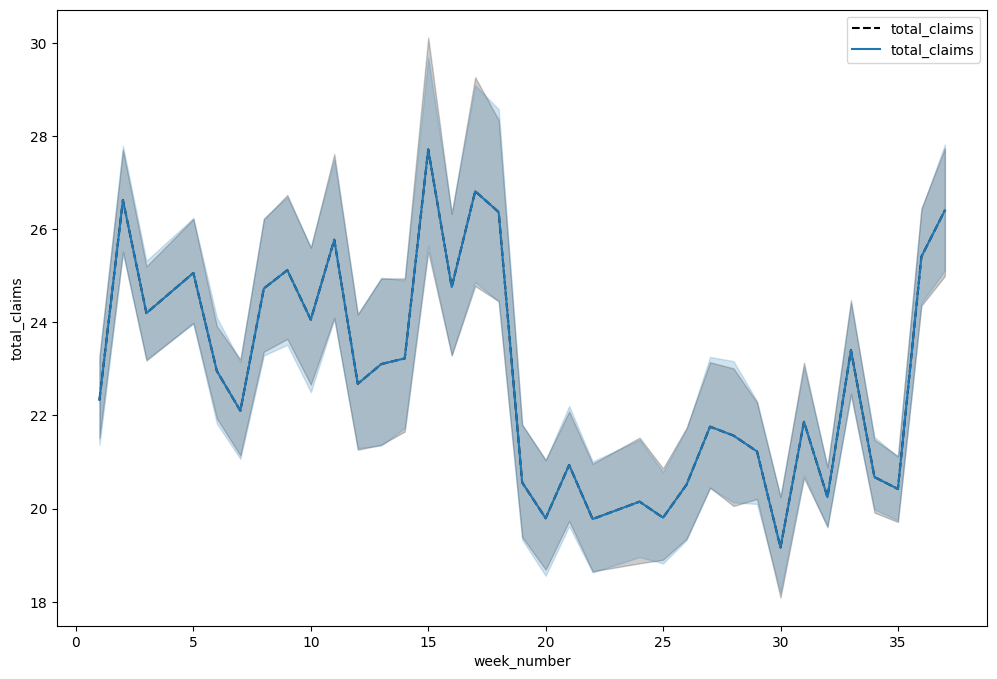

edu_hs_grad_equiv (1.0, 0.4980392156862745, 0.054901960784313725)


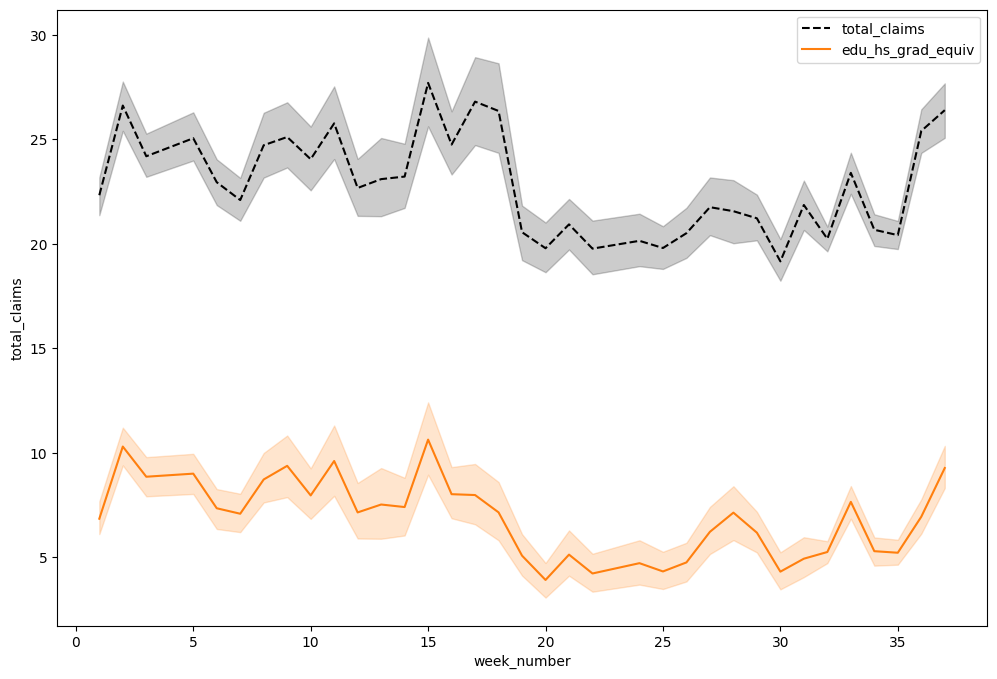

gender_female (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)


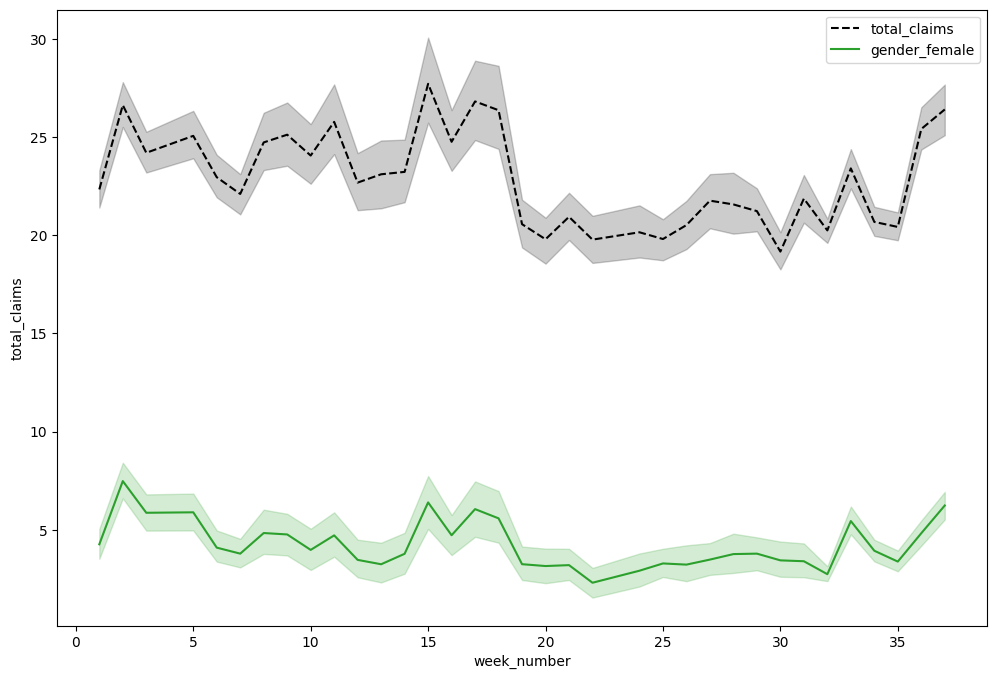

gender_male (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)


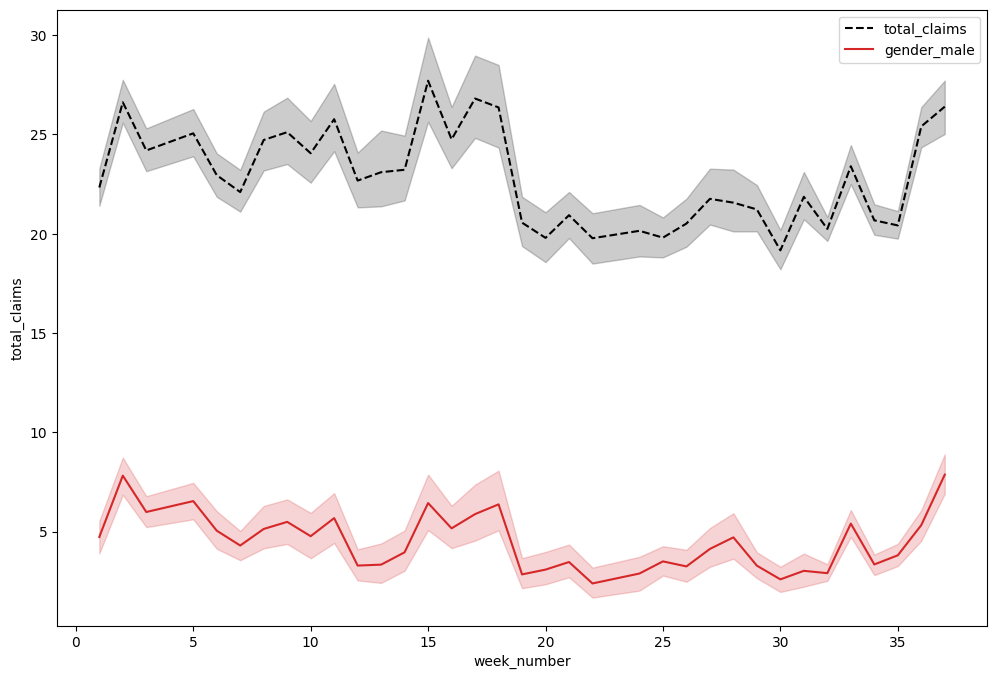

normalized_races (0.5803921568627451, 0.403921568627451, 0.7411764705882353)


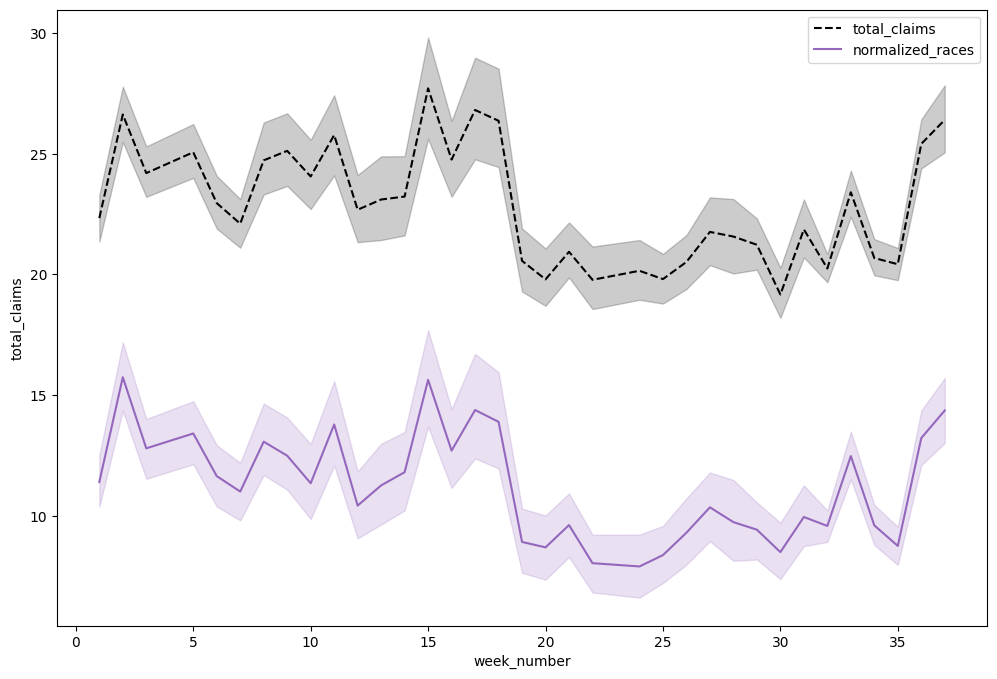

normalized_education (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)


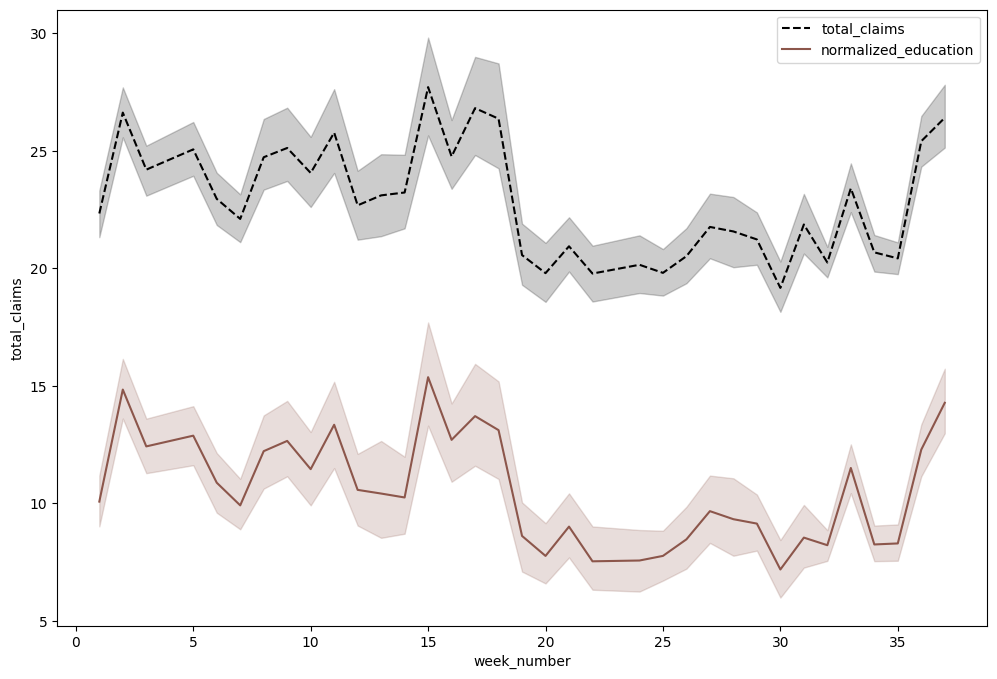

normalized_gender (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)


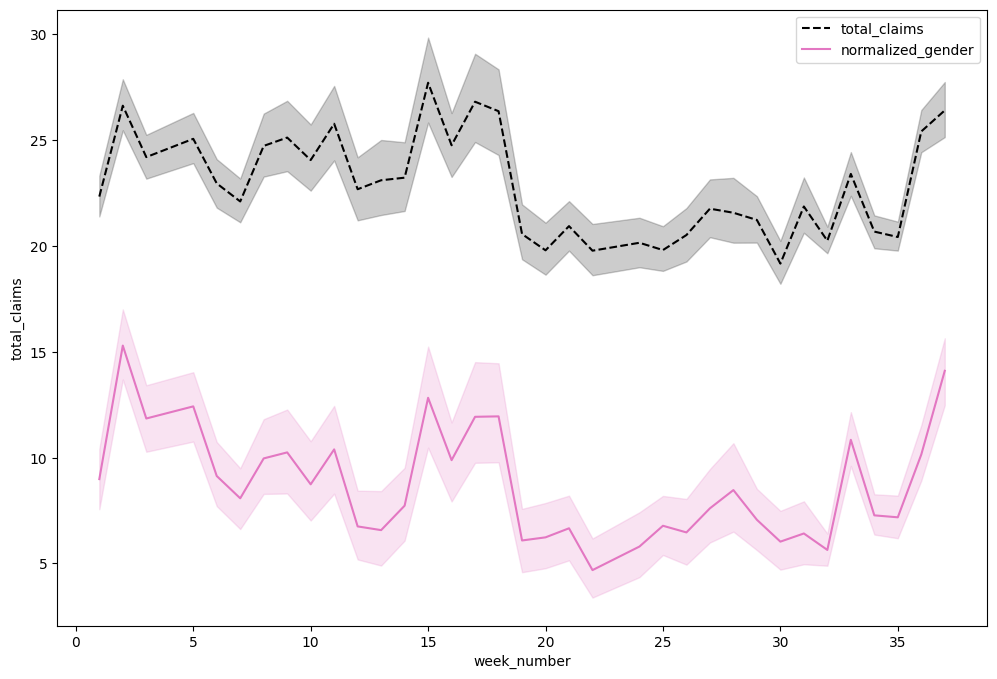

sum (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)


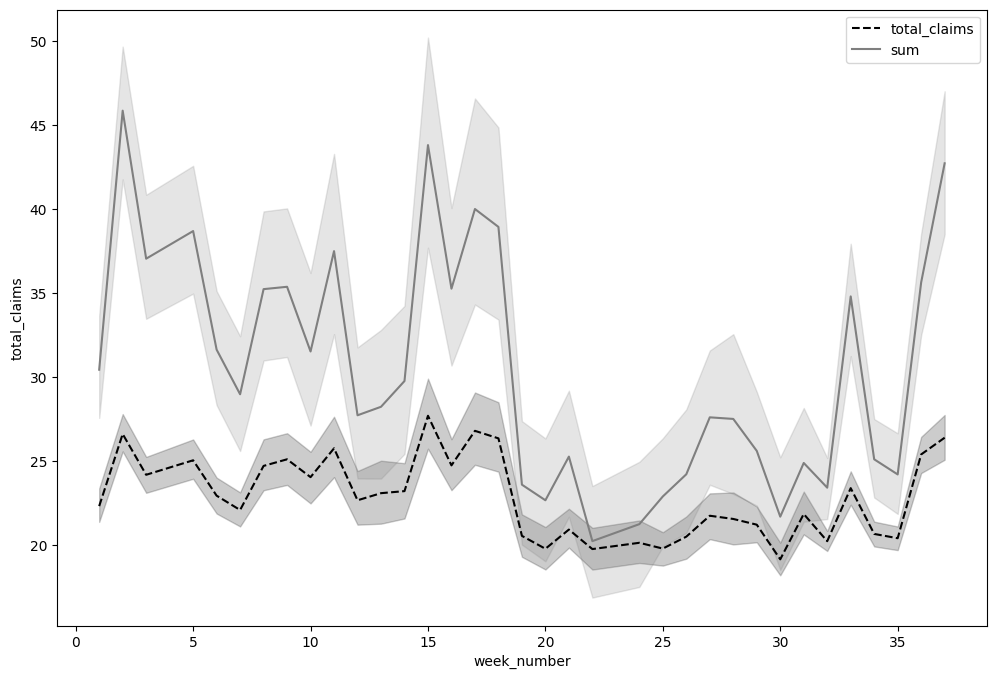

opt_var (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)


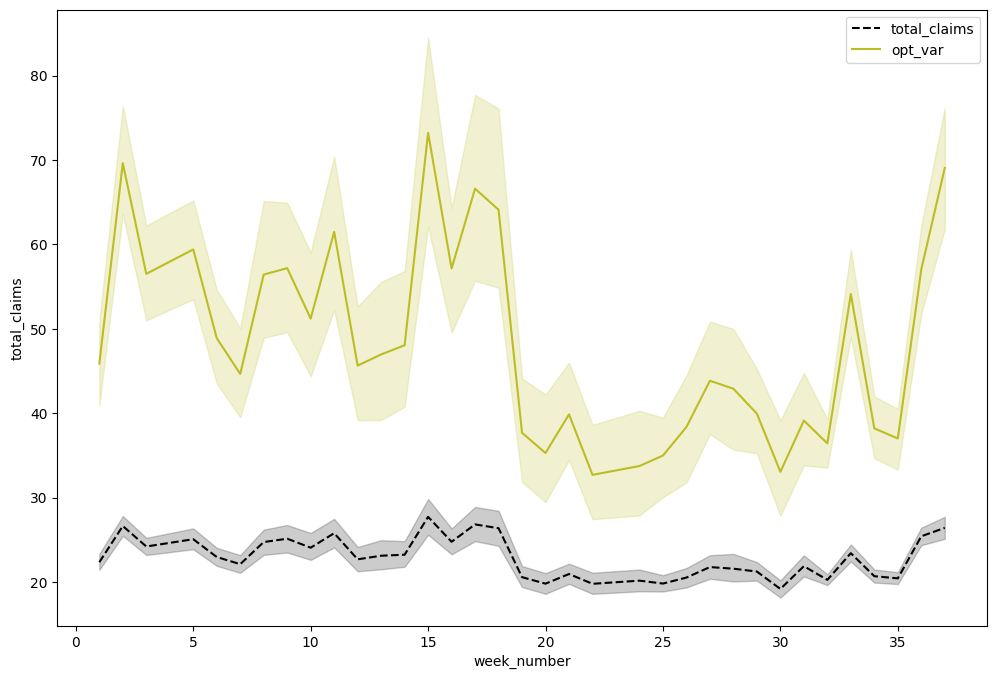

opt_var2 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)


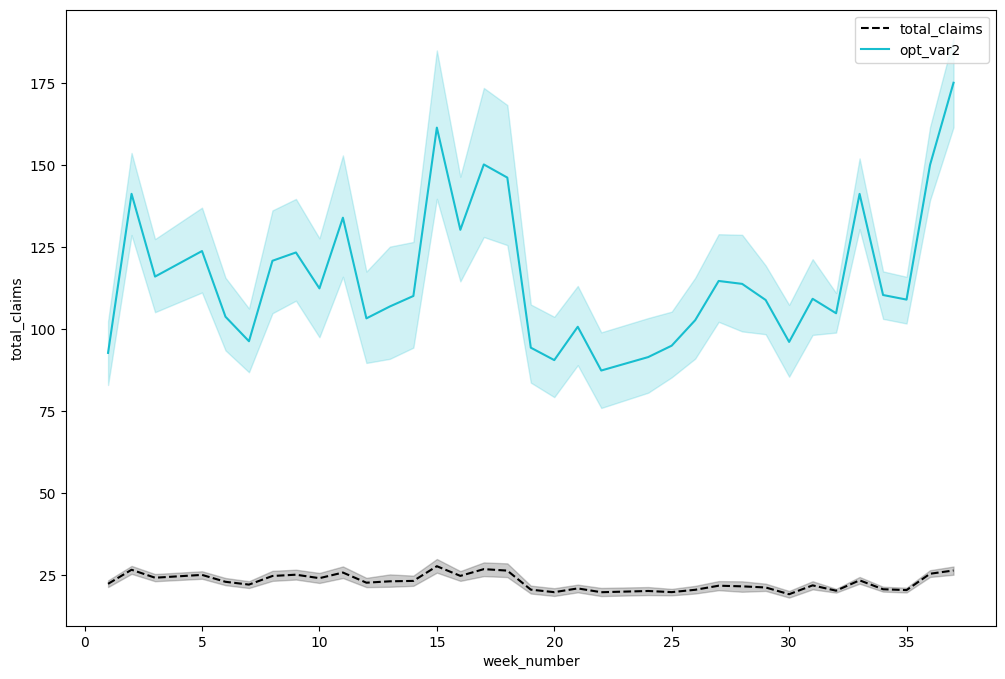

error (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)


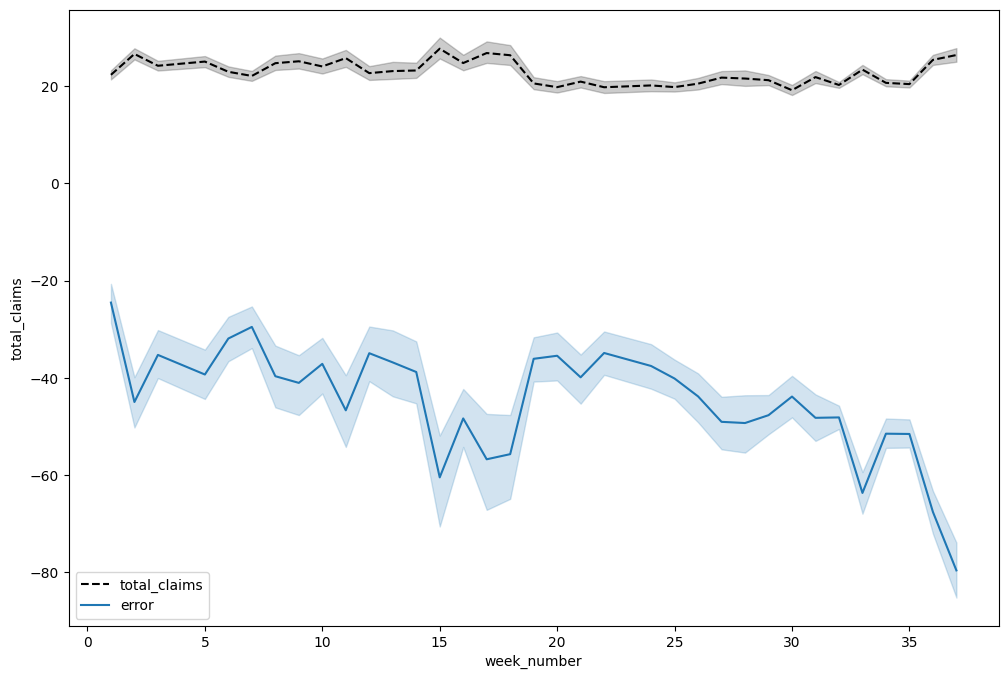

In [30]:
import itertools
colors = itertools.cycle(sns.color_palette("tab10"))
for feature in features:
    fig, ax = plt.subplots(figsize=(12,8)) 
    c = next(colors)
    print(feature, c)
    #sns.scatterplot(x= feature, y = "week_number", data =df3)
    sns.lineplot(y= "total_claims", x = "week_number", data =df3, color = "black", label = "total_claims", linestyle= "--")
    sns.lineplot(y= feature, x = "week_number", data =df3, color = c, label = feature)
    plt.show()

In [31]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as rg
sc = StandardScaler()

In [32]:
def final_pred(t):
    Y = np.array(t["total_claims"])
    X = np.array(t[[k for k in features]])
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size =0.01, random_state =5)
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    rf = rg(n_estimators=1000, random_state=2)
    rf.fit(X_train, Y_train)
    return rf

In [33]:
temp = df3[[k for k in features]]
temp

,total_claims,edu_hs_grad_equiv,gender_female,gender_male,normalized_races,normalized_education,normalized_gender,sum,opt_var,opt_var2,error
0,22.0,14.0,0.0,0.0,11.0,14.0,0.0,25.0,44.988963,105.977927,-38.988963
1,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,9.000000,2.000000
2,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,37.000000,-25.000000
3,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,13.000000,-1.000000
4,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,8.000000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...
16828,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,12.000000,0.000000
16829,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,8.000000,3.000000
16830,16.0,10.0,0.0,0.0,0.0,10.0,0.0,10.0,25.827732,82.655463,-40.827732
16831,23.0,19.0,0.0,0.0,0.0,19.0,0.0,19.0,49.409365,107.818730,-35.409365


In [34]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.prediction_list`
"""

In [35]:
query_job3 = bigquery_client.query(query)
test_df = query_job3.to_dataframe()
#test_df["time"] = pd.datetime(2022-09-24, format = %Y%m%d)
test_df["day"] = 6
test_df["month"]=11

In [36]:
test_df.drop_duplicates()

,uu_id,week_number,day,month
0,5bf51fc2e162d6faf9e3cf79e4198378,44,6,11
1,420b44cc7e3f55d738df565421e59941,44,6,11
2,e39c66ecceec76ee8f9f811fa4a2d246,44,6,11
3,a90462cd11ae4e43144239bf7c4828a4,44,6,11
4,8b20a6749088c7ff1237983076ebfeaa,44,6,11
...,...,...,...,...
520,46c4f6c75e663b1ca82ea7994e6d83d3,44,6,11
521,1deebda501712e7595b531b8337bc31a,44,6,11
522,5a9758f65f001b6432ff31ff64a459d7,44,6,11
523,e8b3b95e93a6dc7dbb90f4e72e7ac065,44,6,11


In [37]:
"""extras = set(test_df.uu_id.unique())-set(submission_prediction_output.uu_id.unique())
extra = [df.loc[df.uu_id==k]["uu_id_enc"].values[0] for k in extras]
extra"""

'extras = set(test_df.uu_id.unique())-set(submission_prediction_output.uu_id.unique())\nextra = [df.loc[df.uu_id==k]["uu_id_enc"].values[0] for k in extras]\nextra'

In [38]:
test_df = pd.merge(test_df, df3[["uu_id","uu_id_enc"]], on="uu_id").drop(["uu_id"], axis=1).drop_duplicates()
feature_test_pred = test_df.copy()
test_df

,week_number,day,month,uu_id_enc
0,44,6,11,198.0
10,44,6,11,126.0
18,44,6,11,476.0
32,44,6,11,353.0
58,44,6,11,288.0
...,...,...,...,...
16684,44,6,11,144.0
16722,44,6,11,52.0
16757,44,6,11,192.0
16781,44,6,11,486.0


In [39]:
"""test_df1=test_df.copy()
for col in ['total_claims', 'edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']:
    print(col)
    test_df[col]=0
    val = ("rf")+"_"+str(col) 
    for k in extra:
        #test_df.loc[test_df.uu_id_enc==k,col] =0
        temp=df[df.uu_id_enc == k]
        temp["average_wage"]=-9999
        temp =temp.replace("",0)
        feature_test_pred = np.array(test_df1[test_df1.uu_id_enc==k])
        #print(k, temp)
        val = time_pred(temp, col)
        #print(test_df.loc[test_df.uu_id_enc==k,col],val.predict(np.array(feature_test_pred)))
        idk = float(val.predict(np.array(feature_test_pred))[0])
        print(idk)
        test_df.loc[test_df.uu_id_enc==k,col].value  = idk
test_df"""

'test_df1=test_df.copy()\nfor col in [\'total_claims\', \'edu_8th_or_less\', \'edu_grades_9_11\',\n       \'edu_hs_grad_equiv\', \'edu_post_hs\', \'edu_unknown\',\n       \'top_category_employer1\', \'top_category_employer2\',\n       \'top_category_employer3\', \'gender_female\', \'gender_male\', \'gender_na\',\n       \'race_amerindian\', \'race_asian\', \'race_black\', \'race_noanswer\',\n       \'race_hawaiiannative\', \'race_other\', \'race_white\', \'average_wage\']:\n    print(col)\n    test_df[col]=0\n    val = ("rf")+"_"+str(col) \n    for k in extra:\n        #test_df.loc[test_df.uu_id_enc==k,col] =0\n        temp=df[df.uu_id_enc == k]\n        temp["average_wage"]=-9999\n        temp =temp.replace("",0)\n        feature_test_pred = np.array(test_df1[test_df1.uu_id_enc==k])\n        #print(k, temp)\n        val = time_pred(temp, col)\n        #print(test_df.loc[test_df.uu_id_enc==k,col],val.predict(np.array(feature_test_pred)))\n        idk = float(val.predict(np.array(featur

In [40]:
df3

,uu_id,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,...,month,day,uu_id_enc,normalized_races,normalized_education,normalized_gender,sum,opt_var,opt_var2,error
0,f013068de98db1470bd986137a0c6d23,16.0,18003.0,900.0,451,22.0,0.0,0.0,14.0,0.0,...,4.0,16.0,494.0,11.0,14.0,0.0,25.0,44.988963,105.977927,-38.988963
1,f013068de98db1470bd986137a0c6d23,7.0,18003.0,900.0,451,10.0,0.0,0.0,0.0,0.0,...,2.0,12.0,494.0,0.0,0.0,0.0,0.0,1.000000,9.000000,2.000000
2,f013068de98db1470bd986137a0c6d23,35.0,18003.0,900.0,451,11.0,0.0,0.0,0.0,0.0,...,8.0,27.0,494.0,0.0,0.0,0.0,0.0,1.000000,37.000000,-25.000000
3,f013068de98db1470bd986137a0c6d23,11.0,18003.0,900.0,451,11.0,0.0,0.0,0.0,0.0,...,3.0,12.0,494.0,0.0,0.0,0.0,0.0,1.000000,13.000000,-1.000000
4,f013068de98db1470bd986137a0c6d23,6.0,18003.0,900.0,451,11.0,0.0,0.0,0.0,0.0,...,2.0,5.0,494.0,0.0,0.0,0.0,0.0,1.000000,8.000000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16828,33f8f477e670b3cac704f4c0faa6e318,10.0,18113.0,971900.0,516,11.0,0.0,0.0,0.0,0.0,...,3.0,5.0,100.0,0.0,0.0,0.0,0.0,1.000000,12.000000,0.000000
16829,33f8f477e670b3cac704f4c0faa6e318,6.0,18113.0,971900.0,516,10.0,0.0,0.0,0.0,0.0,...,2.0,5.0,100.0,0.0,0.0,0.0,0.0,1.000000,8.000000,3.000000
16830,33f8f477e670b3cac704f4c0faa6e318,31.0,18113.0,971900.0,516,16.0,0.0,0.0,10.0,0.0,...,7.0,30.0,100.0,0.0,10.0,0.0,10.0,25.827732,82.655463,-40.827732
16831,33f8f477e670b3cac704f4c0faa6e318,9.0,18113.0,971900.0,516,23.0,0.0,0.0,19.0,0.0,...,2.0,26.0,100.0,0.0,19.0,0.0,19.0,49.409365,107.818730,-35.409365


In [41]:
from statsmodels.tsa.stattools import adfuller
adfuller(df3["total_claims"])

(-15.17531611425795,
 6.306874201039816e-28,
 25,
 16807,
 {'1%': -3.430739141371555,
  '5%': -2.8617119850098525,
  '10%': -2.566861543233935},
 134499.30246634077)

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

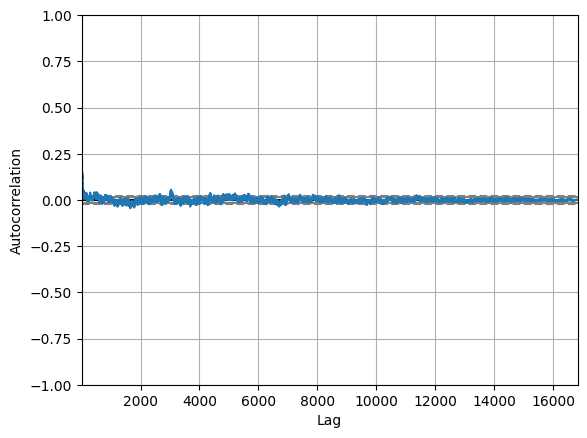

In [42]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df3["total_claims"])

In [43]:
df3 =df3.dropna()
for col in features:
    print(col)
    test_df[col]=0
    val = ("rf")+"_"+str(col) 
    for k in df3.uu_id_enc.unique():
        temp=df3[df3.uu_id_enc == k]
        val = time_pred(temp, col)
        #print(test_df.loc[test_df.uu_id_enc==k,col],val.predict(np.array(feature_test_pred)))
        test_df.loc[test_df.uu_id_enc==k,col] = val.predict(np.array(feature_test_pred))[0]
test_df

total_claims


NameError: name 'time_pred' is not defined

In [44]:
#df3 =df3.dropna()
li=[]
import statsmodels.api as sm
import statistics    
for k in df3.uu_id_enc.unique():
    temp=df3[df3.uu_id_enc == k]
    temp = temp.sort_values("week_number")
    df3_ = pd.concat([temp,test_df])
    df3_=df3_[["week_number","uu_id_enc","total_claims"]].drop_duplicates()
    #df3_["predicted_total_claims"]=0
    mod = sm.tsa.statespace.SARIMAX(np.array(temp["total_claims"]),
                            order=(1, 1, 1),
                            seasonal_order=(1, 1, 1, 2),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
    try: 
        results = mod.fit()
    except IndexError:
        g = df3[df3.uu_id_enc==k]
        val= g[g.week_number==39]['total_claims'].mean()
    pred = results.get_prediction(start=40, end =40, dynamic=False)
    val = (pred.predicted_mean)
    test_df.loc[test_df.uu_id_enc==k,"total_claims"] = val
    li.append(pred.predicted_mean)
    pred_ci = pred.conf_int()
    #print(test_df.loc[test_df.uu_id_enc==k,col],val.predict(np.array(feature_test_pred)))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.51304D+00    |proj g|=  7.30584D-02

At iterate    5    f=  2.36879D+00    |proj g|=  3.32271D-01

At iterate   10    f=  2.23125D+00    |proj g|=  8.98104D-02

At iterate   15    f=  2.21721D+00    |proj g|=  5.25696D-02

At iterate   20    f=  2.21388D+00    |proj g|=  5.54572D-03

At iterate   25    f=  2.21384D+00    |proj g|=  5.29234D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     35      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.34747D+00    |proj g|=  8.42905D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     28      1     0     0   2.994D-06   3.347D+00
  F =   3.3474265098830625     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.32332D+00    |proj g|=  9.24847D-02

At iterate    5    f=  4.30787D+00    |proj g|=  1.33549D-02

At iterate   10    f=  4.28793D+00    |proj g|=  2.41567D-02

At iter


At iterate   20    f=  3.05504D+00    |proj g|=  2.28576D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     27      1     0     0   2.082D-05   3.055D+00
  F =   3.0550403701921685     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99951D+00    |proj g|=  6.55531D-02

At iterate    5    f=  2.88266D+00    |proj g|=  1.34661D-01

At iterate   10    f=  2.75969D+00    |proj g|=  2.61938D-02

At iter


At iterate   10    f=  3.48105D+00    |proj g|=  1.18312D-01

At iterate   15    f=  3.44817D+00    |proj g|=  7.07627D-03

At iterate   20    f=  3.44810D+00    |proj g|=  5.51027D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     25      1     0     0   9.949D-06   3.448D+00
  F =   3.4480953569994686     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84532D+00    |proj g|=  3.11040D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     21      1     0     0   1.841D+15  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19548D+00    |proj g|=  2.88887D-02

At iterate    5    f=  3.18798D+00    |proj g|=  1.33516D-02

At iterate   10    f=  3.17927D+00    |proj g|=  4.65527D-03

At iterate   15    f=  3.17922D+00    |proj g|=  1.96317D-04

       

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80936D+00    |proj g|=  3.61850D-02

At iterate    5    f=  2.75771D+00    |proj g|=  2.74771D-02

At iterate   10    f=  2.75654D+00    |proj g|=  4.56870D-04

At iterate   15    f=  2.75653D+00    |proj g|=  2.67999D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     21      1     0     0   2.680D-06   2.757D+00
  F =   2.7565332919450292     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48428D+00    |proj g|=  1.04692D-01

At iterate    5    f=  3.44432D+00    |proj g|=  2.58522D-02

At iterate   10    f=  3.39994D+00    |proj g|=  1.26853D-01

At iterate   15    f=  3.32217D+00    |proj g|=  5.79645D-02

At iterate   20    f=  3.29514D+00    |proj g|=  8.60600D-03

At iterate   25    f=  3.29505D+00    |proj g|=  1.18221D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     36      1     0     0   


At iterate   10    f=  2.60482D+00    |proj g|=  1.43105D-03

At iterate   15    f=  2.60048D+00    |proj g|=  1.76887D-01

At iterate   20    f=  2.59647D+00    |proj g|=  6.36617D-02

At iterate   25    f=  2.59429D+00    |proj g|=  1.96315D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     44      1     0     0   9.683D-05   2.594D+00
  F =   2.5942901909737941     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.50878D+00    |proj g|=  5.99518D-02

At iterate   10    f=  3.41728D+00    |proj g|=  1.15659D-01

At iterate   15    f=  3.39129D+00    |proj g|=  7.45724D-02

At iterate   20    f=  3.36725D+00    |proj g|=  6.68478D-02

At iterate   25    f=  3.36569D+00    |proj g|=  6.32310D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     43      1     0     0   1.501D-05   3.366D+00
  F =   3.3656934925099700     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90287D+00    |proj g|=  3.83001D-02

At iterate    5    f=  2.79915D+00    |proj g|=  9.01520D-02

At iterate   10    f=  2.75466D+00    |proj g|=  7.22235D-02

At iterate   15    f=  2.75427D+00    |proj g|=  3.20157D-03

At iterate   20    f=  2.75417D+00    |proj g|=  1.35116D-02

At iterate   25    f=  2.75416D+00    |proj g|=  2.16913D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     35      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.59368D+00    |proj g|=  1.98671D-02

At iterate   20    f=  2.59341D+00    |proj g|=  1.50129D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     32      1     0     0   1.113D-06   2.593D+00
  F =   2.5934099227177034     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16198D+00    |proj g|=  9.92862D-02

At iterate    5    f=  3.13457D+00    |proj g|=  2.93804D-02

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.41558D+00    |proj g|=  3.88033D-01

At iterate    5    f=  3.25805D+00    |proj g|=  1.83536D-02

At iterate   10    f=  3.17612D+00    |proj g|=  3.89233D-02

At iterate   15    f=  3.17342D+00    |proj g|=  1.24128D-02

At iterate   20    f=  3.17238D+00    |proj g|=  3.67577D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     24      1     0     0   1.320D-05   3.172D+00
  F =   3.1723847327862513     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  3.68695D+00    |proj g|=  5.81907D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     36      1     0     0   5.203D-06   3.687D+00
  F =   3.6869520942362564     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33343D+00    |proj g|=  2.44185D-02

At iterate    5    f=  3.31291D+00    |proj g|=  7.06740D-02

At iterate   10    f=  3.27501D+00    |proj g|=  1.52466D-03

At iter


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     64      2     0     0   5.341D-05   1.948D+00
  F =   1.9483920423795165     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12642D+00    |proj g|=  3.31132D-02

At iterate    5    f=  3.09764D+00    |proj g|=  8.80829D-02

At iterate   10    f=  3.01085D+00    |proj g|=  5.89730D-02

At iterate   15    f=  2.98589D+00    |proj g|=  4.38601D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70709D+00    |proj g|=  5.46739D-01

At iterate    5    f=  1.56521D+00    |proj g|=  2.79226D-01

At iterate   10    f=  1.55181D+00    |proj g|=  5.50535D-02

At iterate   15    f=  1.53975D+00    |proj g|=  8.93721D-02

At iterate   20    f=  1.53472D+00    |proj g|=  3.54795D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     31      1     0     0   3.223D-06   1.535D+00
  F =   1.5347150909247456     

CONVERG

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33218D+00    |proj g|=  3.21565D-02

At iterate    5    f=  3.30529D+00    |proj g|=  1.78610D-02

At iterate   10    f=  3.27515D+00    |proj g|=  5.89350D-02

At iterate   15    f=  3.25549D+00    |proj g|=  3.66375D-02

At iterate   20    f=  3.25213D+00    |proj g|=  1.56678D-03

At iterate   25    f=  3.25210D+00    |proj g|=  7.12195D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     31      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.76576D+00    |proj g|=  2.21405D-02

At iterate   20    f=  3.76337D+00    |proj g|=  2.82801D-03

At iterate   25    f=  3.76334D+00    |proj g|=  3.22347D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     32      1     0     0   3.223D-06   3.763D+00
  F =   3.7633389572393763     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22081D+00    |proj g|=  1.42501D-01

At iter


At iterate   20    f=  3.20937D+00    |proj g|=  8.01302D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     38      1     0     0   4.996D-05   3.209D+00
  F =   3.2093662599662287     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64235D+00    |proj g|=  1.37768D-01

At iterate    5    f=  3.58548D+00    |proj g|=  3.55822D-02

At iterate   10    f=  3.55546D+00    |proj g|=  1.09173D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   10    f=  1.34769D+00    |proj g|=  4.06545D-02

At iterate   15    f=  1.34569D+00    |proj g|=  1.77350D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     32      1     0     0   8.142D-06   1.346D+00
  F =   1.3456876556331339     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.35990D-01    |proj g|=  2.76687D-01

At iterate    5    f=  4.56234D-01    |proj g|=  3.15617D-01

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76925D+00    |proj g|=  1.84786D-01

At iterate    5    f=  2.72225D+00    |proj g|=  1.79064D-02

At iterate   10    f=  2.69134D+00    |proj g|=  5.74373D-02

At iterate   15    f=  2.68564D+00    |proj g|=  2.58383D-03

At iterate   20    f=  2.68560D+00    |proj g|=  3.05956D-05

At iterate   25    f=  2.68560D+00    |proj g|=  3.38030D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     33      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.67089D+00    |proj g|=  7.16297D-02

At iterate   15    f=  3.55631D+00    |proj g|=  3.07303D-02

At iterate   20    f=  3.55551D+00    |proj g|=  4.05691D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     28      1     0     0   1.658D-06   3.556D+00
  F =   3.5555078752055436     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

       


At iterate   20    f=  3.04054D+00    |proj g|=  1.10221D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     31      1     0     0   4.061D-06   3.041D+00
  F =   3.0405370908597353     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44574D+00    |proj g|=  1.20205D-01

At iterate    5    f=  3.40112D+00    |proj g|=  4.30939D-02

At iterate   10    f=  3.38887D+00    |proj g|=  3.87743D-02

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99713D+00    |proj g|=  1.56208D-01

At iterate    5    f=  2.90288D+00    |proj g|=  8.29620D-02

At iterate   10    f=  2.77304D+00    |proj g|=  6.02092D-02

At iterate   15    f=  2.76597D+00    |proj g|=  2.00241D-03

At iterate   20    f=  2.76595D+00    |proj g|=  1.36632D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     27      1     0     0   1.136D-06   2.766D+00
  F =   2.7659532309003376     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.01140D+00    |proj g|=  2.03990D-02

At iterate   15    f=  3.01062D+00    |proj g|=  1.85066D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   9.425D-06   3.011D+00
  F =   3.0106151987580199     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.96225D+00    |proj g|=  2.00286D-01

At iterate    5    f=  1.91220D+00    |proj g|=  3.19062D-02

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16777D+00    |proj g|=  2.33053D-01

At iterate    5    f=  3.11716D+00    |proj g|=  4.94556D-02

At iterate   10    f=  2.99051D+00    |proj g|=  6.11640D-02

At iterate   15    f=  2.98533D+00    |proj g|=  1.03093D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     24      1     0     0   3.011D-05   2.985D+00
  F =   2.9853208596498368     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.92557D+00    |proj g|=  1.30500D-02

At iterate   20    f=  3.92540D+00    |proj g|=  5.50324D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   5.503D-06   3.925D+00
  F =   3.9254014954407070     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53481D+00    |proj g|=  1.43254D-01

At iterate    5    f=  3.50083D+00    |proj g|=  2.52117D-02

At iter


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     34      1     0     0   2.008D-05   3.029D+00
  F =   3.0293076704899375     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91602D+00    |proj g|=  2.62429D-01

At iterate    5    f=  3.88239D+00    |proj g|=  1.48467D-02

At iterate   10    f=  3.84433D+00    |proj g|=  1.11786D-01

At iterate   15    f=  3.69825D+00    |proj g|=  1.43661D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.99832D+00    |proj g|=  1.23567D-01

At iterate   15    f=  3.85227D+00    |proj g|=  4.34675D-02

At iterate   20    f=  3.84853D+00    |proj g|=  4.23482D-03

At iterate   25    f=  3.84852D+00    |proj g|=  1.82867D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     31      1     0     0   1.829D-06   3.849D+00
  F =   3.8485185715289028     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


At iterate    5    f=  2.08551D+00    |proj g|=  4.54377D-02

At iterate   10    f=  2.03373D+00    |proj g|=  2.52330D-02

At iterate   15    f=  2.03126D+00    |proj g|=  9.11840D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     25      1     0     0   2.138D-06   2.031D+00
  F =   2.0312624116182452     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.94738D+00    |proj g|=  1.41720D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.68228D+00    |proj g|=  8.43772D-02

At iterate   15    f=  2.64911D+00    |proj g|=  3.21924D-02

At iterate   20    f=  2.64896D+00    |proj g|=  1.47559D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     35      1     0     0   2.462D-05   2.649D+00
  F =   2.6489616747445806     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71222D+00    |proj g|=  6.95437D-02

At iter


At iterate    5    f=  2.97192D+00    |proj g|=  2.93489D-02

At iterate   10    f=  2.89553D+00    |proj g|=  1.25841D-01

At iterate   15    f=  2.87474D+00    |proj g|=  2.04526D-02

At iterate   20    f=  2.87438D+00    |proj g|=  8.50875D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     30      1     0     0   8.509D-06   2.874D+00
  F =   2.8743813183970000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.84519D+00    |proj g|=  2.57944D-02

At iterate   15    f=  3.70402D+00    |proj g|=  1.16752D-01

At iterate   20    f=  3.68713D+00    |proj g|=  1.68646D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     30      1     0     0   7.705D-06   3.687D+00
  F =   3.6871231852666604     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.54847D+00    |proj g|=  8.62929D-02

At iter


At iterate   15    f=  3.52403D+00    |proj g|=  3.65620D-02

At iterate   20    f=  3.52323D+00    |proj g|=  4.95056D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   4.951D-05   3.523D+00
  F =   3.5232347693157435     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43539D+00    |proj g|=  1.15215D-01

At iterate    5    f=  3.41585D+00    |proj g|=  2.06836D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.05946D+00    |proj g|=  3.67765D-02

At iterate   20    f=  3.05807D+00    |proj g|=  2.46260D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     35      1     0     0   4.336D-07   3.058D+00
  F =   3.0580747219094366     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.93565D+00    |proj g|=  2.42727D-01

At iterate    5    f=  2.84339D+00    |proj g|=  3.35842D-02

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96760D+00    |proj g|=  5.12310D-02

At iterate    5    f=  2.92356D+00    |proj g|=  1.34431D-01

At iterate   10    f=  2.83854D+00    |proj g|=  7.60101D-03

At iterate   15    f=  2.83790D+00    |proj g|=  2.28821D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   2.075D-06   2.838D+00
  F =   2.8378959810836175     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.55952D+00    |proj g|=  1.34823D-01

At iterate   20    f=  3.55075D+00    |proj g|=  4.28903D-03

At iterate   25    f=  3.55073D+00    |proj g|=  3.26440D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     33      1     0     0   1.232D-05   3.551D+00
  F =   3.5507307079847532     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79524D+00    |proj g|=  2.54350D-01

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.73077D+00    |proj g|=  3.88204D-01

At iterate    5    f=  2.55601D+00    |proj g|=  6.09837D-02

At iterate   10    f=  2.47470D+00    |proj g|=  1.30953D-02

At iterate   15    f=  2.47369D+00    |proj g|=  9.43302D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   1.861D-06   2.474D+00
  F =   2.4736851745560631     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.31532D+00    |proj g|=  1.88043D-02

At iterate   10    f=  3.28527D+00    |proj g|=  8.54073D-02

At iterate   15    f=  3.25265D+00    |proj g|=  7.57251D-02

At iterate   20    f=  3.23708D+00    |proj g|=  1.56612D-03

At iterate   25    f=  3.23467D+00    |proj g|=  8.56692D-03

At iterate   30    f=  3.23465D+00    |proj g|=  1.09370D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     44      1     0     0   1.094D-06   3.235D+00
  F =   3.2346525999335203     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.18729D+00    |proj g|=  1.99611D-01

At iterate    5    f=  2.07689D+00    |proj g|=  1.22619D-02
  ys=-5.902E-03  -gs= 6.955E-04 BFGS update SKIPPED

At iterate   10    f=  2.07046D+00    |proj g|=  5.88275D-03

At iterate   15    f=  2.06975D+00    |proj g|=  9.89907D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     31      1     1     0   8.736D-05   2.070D+00
  F =   2.0697535018555802     

CONVERGENCE: REL_

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53431D+00    |proj g|=  6.69140D-02

At iterate    5    f=  3.51234D+00    |proj g|=  7.38519D-02

At iterate   10    f=  3.49256D+00    |proj g|=  1.28372D-02

At iterate   15    f=  3.46927D+00    |proj g|=  8.05202D-03

At iterate   20    f=  3.46544D+00    |proj g|=  2.11924D-01

At iterate   25    f=  3.45987D+00    |proj g|=  5.22775D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     43      1     0     0   

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.35666D+00    |proj g|=  8.77211D-02

At iterate    5    f=  3.33966D+00    |proj g|=  1.51073D-02

At iterate   10    f=  3.31767D+00    |proj g|=  9.90544D-03

At iterate   15    f=  3.31542D+00    |proj g|=  6.25220D-02

At iterate   20    f=  3.30725D+00    |proj g|=  1.54198D-02

At iterate   25    f=  3.30709D+00    |proj g|=  1.75396D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     37      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.38482D+00    |proj g|=  2.30480D-03

At iterate   20    f=  3.38482D+00    |proj g|=  9.74198D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     36      1     0     0   1.336D-06   3.385D+00
  F =   3.3848180649955295     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72285D+00    |proj g|=  1.65769D-01

At iterate    5    f=  1.55953D+00    |proj g|=  7.67088D+00

At iter


At iterate    5    f=  1.95242D+00    |proj g|=  1.34547D-01

At iterate   10    f=  1.94241D+00    |proj g|=  3.27647D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     19      1     0     0   1.909D-06   1.942D+00
  F =   1.9423953967105509     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28503D+00    |proj g|=  9.83726D-02

At iterate    5    f=  3.22441D+00    |proj g|=  4.93001D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37891D+00    |proj g|=  1.08125D-01

At iterate    5    f=  2.31772D+00    |proj g|=  9.36091D-02

At iterate   10    f=  2.27308D+00    |proj g|=  6.29704D-01

At iterate   15    f=  2.26426D+00    |proj g|=  4.65255D-02

At iterate   20    f=  2.26419D+00    |proj g|=  1.93381D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     29      1     0     0   1.934D-05   2.264D+00
  F =   2.2641947382649374     

CONVERG


At iterate   15    f=  3.11295D+00    |proj g|=  3.96365D-02

At iterate   20    f=  3.11090D+00    |proj g|=  2.07531D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     34      1     0     0   3.610D-05   3.111D+00
  F =   3.1108889405116780     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.41954D+00    |proj g|=  1.97014D-01

At iterate    5    f=  2.29266D+00    |proj g|=  2.59629D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09216D+00    |proj g|=  1.60762D-01

At iterate    5    f=  4.05842D+00    |proj g|=  1.41652D-02

At iterate   10    f=  4.04329D+00    |proj g|=  6.70825D-02

At iterate   15    f=  4.03608D+00    |proj g|=  3.72173D-02

At iterate   20    f=  3.98517D+00    |proj g|=  1.43317D-01

At iterate   25    f=  3.91335D+00    |proj g|=  1.28078D-01

At iterate   30    f=  3.89936D+00    |proj g|=  2.60932D-03

At iterate   35    f=  3.89936D+00    |proj g|=  5.41241D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


At iterate   20    f=  3.12673D+00    |proj g|=  3.86600D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     30      1     0     0   3.250D-06   3.127D+00
  F =   3.1267306960977264     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54317D+00    |proj g|=  5.76264D-02

At iterate    5    f=  2.49546D+00    |proj g|=  5.95059D-02

At iterate   10    f=  2.47957D+00    |proj g|=  1.42327D-02

At iterate   15    f=  2.47885D+00    |proj g|=  5.08155D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     22      1     0     0   7.535D-07   2.479D+00
  F =   2.4788535452028433     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 


At iterate    5    f=  3.82141D+00    |proj g|=  1.75309D-02

At iterate   10    f=  3.78832D+00    |proj g|=  5.36442D-02

At iterate   15    f=  3.68416D+00    |proj g|=  1.36170D-01

At iterate   20    f=  3.65716D+00    |proj g|=  2.01519D-03

At iterate   25    f=  3.65690D+00    |proj g|=  6.62405D-03

At iterate   30    f=  3.65685D+00    |proj g|=  7.62448D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     37      1     0     0   7.624D-05   3.657D+00
  F =   3.6568472756637855     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.58069D+00    |proj g|=  5.45012D-02

At iterate   25    f=  3.57895D+00    |proj g|=  1.06220D-02

At iterate   30    f=  3.57862D+00    |proj g|=  1.19123D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     41      1     0     0   7.223D-06   3.579D+00
  F =   3.5786216825471038     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91276D+00    |proj g|=  1.22842D-01

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.80006D+00    |proj g|=  1.25717D-01

At iterate    5    f=  3.73580D+00    |proj g|=  2.43905D-02

At iterate   10    f=  3.54833D+00    |proj g|=  1.86402D-01

At iterate   15    f=  3.46830D+00    |proj g|=  1.61484D-02

At iterate   20    f=  3.46722D+00    |proj g|=  1.28501D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     31      1     0     0   5.283D-06   3.467D+00
  F =   3.4672148579411415     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.21754D+00    |proj g|=  6.00138D-02

At iterate    5    f=  4.20653D+00    |proj g|=  2.37303D-02

At iterate   10    f=  4.01158D+00    |proj g|=  3.17908D-01

At iterate   15    f=  3.94703D+00    |proj g|=  5.99801D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     24      1     0     0   5.026D-06   3.947D+00
  F =   3.9470259282541154     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 


At iterate    5    f=  3.52212D+00    |proj g|=  2.66796D-02

At iterate   10    f=  3.39632D+00    |proj g|=  1.91307D-01

At iterate   15    f=  3.33203D+00    |proj g|=  8.12182D-02

At iterate   20    f=  3.33092D+00    |proj g|=  1.67215D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     27      1     0     0   8.255D-05   3.331D+00
  F =   3.3309155117058133     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  2.85102D+00    |proj g|=  9.57243D-03

At iterate   15    f=  2.85060D+00    |proj g|=  1.52942D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     21      1     0     0   2.070D-06   2.851D+00
  F =   2.8506042706270041     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44508D+00    |proj g|=  5.52821D-02

At iterate    5    f=  3.42707D+00    |proj g|=  2.38309D-01

At iter


At iterate   20    f=  3.12034D+00    |proj g|=  4.63901D-02

At iterate   25    f=  3.11760D+00    |proj g|=  9.33215D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     33      1     0     0   2.041D-05   3.118D+00
  F =   3.1175948516018690     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56775D+00    |proj g|=  1.28425D-01

At iterate    5    f=  3.51677D+00    |proj g|=  4.21425D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  3.60326D+00    |proj g|=  6.64190D-02

At iterate   35    f=  3.59770D+00    |proj g|=  2.31711D-03

At iterate   40    f=  3.59768D+00    |proj g|=  3.22212D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     60      1     0     0   3.222D-05   3.598D+00
  F =   3.5976814891267788     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.90946D+00    |proj g|=  1.15236D-01

At iter


At iterate   10    f=  4.19108D+00    |proj g|=  2.78745D-02

At iterate   15    f=  4.06286D+00    |proj g|=  3.36571D-02

At iterate   20    f=  4.06103D+00    |proj g|=  5.32589D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     32      1     0     0   1.151D-05   4.061D+00
  F =   4.0610322140103214     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33228D+00    |proj g|=  4.30767D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.87039D+00    |proj g|=  2.62392D-02

At iterate   10    f=  2.86996D+00    |proj g|=  6.16123D-03

At iterate   15    f=  2.86866D+00    |proj g|=  8.15292D-03

At iterate   20    f=  2.86850D+00    |proj g|=  4.97429D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     31      1     0     0   1.310D-06   2.868D+00
  F =   2.8684794905849591     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


At iterate    5    f=  3.90346D+00    |proj g|=  1.56443D-02

At iterate   10    f=  3.88005D+00    |proj g|=  8.08164D-02

At iterate   15    f=  3.82715D+00    |proj g|=  1.16213D-01

At iterate   20    f=  3.81222D+00    |proj g|=  1.48412D-02

At iterate   25    f=  3.81129D+00    |proj g|=  6.64369D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     36      1     0     0   6.884D-06   3.811D+00
  F =   3.8112587175791544     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.57273D+00    |proj g|=  6.20431D-02

At iterate   10    f=  2.52180D+00    |proj g|=  6.12982D-02

At iterate   15    f=  2.51935D+00    |proj g|=  1.08819D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     25      1     0     0   1.409D-06   2.519D+00
  F =   2.5193482190934060     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.54421D+00    |proj g|=  1.17673D-01

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.06623D+00    |proj g|=  1.24332D-01

At iterate    5    f=  3.01862D+00    |proj g|=  5.67265D-02

At iterate   10    f=  2.98850D+00    |proj g|=  4.06667D-02

At iterate   15    f=  2.92604D+00    |proj g|=  4.74374D-02

At iterate   20    f=  2.92390D+00    |proj g|=  1.49929D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     29      1     0     0   2.903D-05   2.924D+00
  F =   2.9238976371926415     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.60131D+00    |proj g|=  2.02429D-02

At iterate   10    f=  2.59480D+00    |proj g|=  2.31543D-02

At iterate   15    f=  2.50117D+00    |proj g|=  2.81258D-01

At iterate   20    f=  2.45850D+00    |proj g|=  7.27733D-02

At iterate   25    f=  2.45800D+00    |proj g|=  5.47025D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     40      1     0     0   1.101D-04   2.458D+00
  F =   2.4579980880961330     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10


At iterate   15    f=  2.12579D+00    |proj g|=  4.50458D-02

At iterate   20    f=  2.12443D+00    |proj g|=  1.77321D-03

At iterate   25    f=  2.12443D+00    |proj g|=  9.58005D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     56      1     0     0   5.450D-03   2.124D+00
  F =   2.1244263482337105     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.82705D+00    |proj g|=  4.81440D-02

At iter


At iterate   10    f=  1.80666D+00    |proj g|=  3.39370D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     18      1     0     0   9.393D-06   1.806D+00
  F =   1.8064754853270548     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18583D+00    |proj g|=  1.96265D-01

At iterate    5    f=  3.12105D+00    |proj g|=  2.96277D-02

At iterate   10    f=  3.03419D+00    |proj g|=  6.75481D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  3.09235D+00    |proj g|=  4.09131D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     36      1     0     0   5.524D-06   3.092D+00
  F =   3.0923518814571116     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.36002D+00    |proj g|=  2.16191D-01

At iterate    5    f=  2.33127D+00    |proj g|=  9.15596D-02

At iterate   10    f=  2.27572D+00    |proj g|=  9.61538D-02

At iterate   15    f=  2.27547D+00    |proj g|=  9.63787D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     25      1     0     0   5.409D-05   2.275D+00
  F =   2.2754745163239738     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 


At iterate   20    f=  2.53076D+00    |proj g|=  5.21311D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     29      1     0     0   3.052D-06   2.531D+00
  F =   2.5307578261715906     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54999D+00    |proj g|=  1.92521D-01


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.49084D+00    |proj g|=  1.95823D-02

At iterate   10    f=  2.47220D+00    |proj g|=  1.31641D-01

At iterate   15    f=  2.45383D+00    |proj g|=  1.43999D-01

At iterate   20    f=  2.45275D+00    |proj g|=  2.98338D-01

At iterate   25    f=  2.44961D+00    |proj g|=  3.34116D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     48      1     0     0   1.132D-04   2.450D+00
  F =   2.4496047138625023     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10


At iterate    0    f=  1.24638D+00    |proj g|=  2.62416D-01

At iterate    5    f=  1.16611D+00    |proj g|=  5.49685D-01

At iterate   10    f=  1.11623D+00    |proj g|=  3.02401D-01

At iterate   15    f=  1.00441D+00    |proj g|=  2.26357D-01

At iterate   20    f=  9.98892D-01    |proj g|=  3.02660D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     30      1     0     0   5.521D-06   9.989D-01
  F =  0.99888928659750431     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.62278D+00    |proj g|=  6.12608D-03

At iterate   15    f=  2.62212D+00    |proj g|=  1.26057D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     28      1     0     0   5.534D-05   2.622D+00
  F =   2.6220826605923535     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.78177D+00    |proj g|=  1.72212D-01

At iterate    5    f=  2.72201D+00    |proj g|=  1.12085D-01

At iter


At iterate    5    f=  1.90615D+00    |proj g|=  1.38225D-01

At iterate   10    f=  1.88019D+00    |proj g|=  2.04361D-03

At iterate   15    f=  1.87916D+00    |proj g|=  2.73235D-02

At iterate   20    f=  1.87738D+00    |proj g|=  4.02588D-03

At iterate   25    f=  1.87705D+00    |proj g|=  1.38072D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     33      1     0     0   7.084D-06   1.877D+00
  F =   1.8770469938689529     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.49001D+00    |proj g|=  6.47522D-02

At iterate    5    f=  2.42429D+00    |proj g|=  1.47543D-01

At iterate   10    f=  2.32791D+00    |proj g|=  1.60724D-01

At iterate   15    f=  2.30114D+00    |proj g|=  1.63101D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     22      1     0     0   2.382D-06   2.301D+00
  F =   2.3011385257222510     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 


At iterate   10    f=  3.09900D+00    |proj g|=  6.08016D-02

At iterate   15    f=  3.09314D+00    |proj g|=  2.01134D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   4.328D-05   3.093D+00
  F =   3.0931361265772175     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.27981D+00    |proj g|=  1.38977D-01

At iterate    5    f=  1.91459D+00    |proj g|=  8.08761D-03


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.88050D+00    |proj g|=  2.61314D-02

At iterate   15    f=  1.82885D+00    |proj g|=  1.28851D-02

At iterate   20    f=  1.82774D+00    |proj g|=  1.39881D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     27      1     0     0   3.269D-06   1.828D+00
  F =   1.8277441534521952     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.34586D+00    |proj g|=  2.06028D-01

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15336D+00    |proj g|=  3.36946D-02

At iterate    5    f=  3.03776D+00    |proj g|=  1.57565D-01

At iterate   10    f=  2.92770D+00    |proj g|=  9.86188D-03


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     20      1     0     0   2.886D-06   2.928D+00
  F =   2.9276204300537683     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75566D+00    |proj g|=  6.73720D-02

At iterate    5    f=  3.73722D+00    |proj g|=  1.77299D-02

At iterate   10    f=  3.61184D+00    |proj g|=  6.37206D-02

At iterate   15    f=  3.60544D+00    |proj g|=  2.35031D-03

       


At iterate    5    f=  3.14045D+00    |proj g|=  8.31622D-02

At iterate   10    f=  3.09060D+00    |proj g|=  7.30512D-02

At iterate   15    f=  3.05477D+00    |proj g|=  1.73461D-02


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.05469D+00    |proj g|=  5.18436D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     31      1     0     0   6.091D-06   3.055D+00
  F =   3.0546878216714877     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55912D+00    |proj g|=  2.43391D-01

At iterate    5    f=  3.46193D+00    |proj g|=  4.84962D-02

At iterate   10    f=  3.44766D+00    |proj g|=  7.30111D-02

At iter


At iterate   15    f=  2.51102D+00    |proj g|=  1.17282D-01


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.50296D+00    |proj g|=  1.21392D-02

At iterate   25    f=  2.50295D+00    |proj g|=  1.77896D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     32      1     0     0   1.779D-05   2.503D+00
  F =   2.5029450435551408     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.78604D+00    |proj g|=  1.08559D-01

At iterate    5    f=  2.71274D+00    |proj g|=  9.50785D-02

At iter


At iterate   10    f=  9.63174D-01    |proj g|=  3.89762D-02

At iterate   15    f=  9.60732D-01    |proj g|=  1.18022D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     24      1     0     0   3.532D-06   9.607D-01
  F =  0.96073128964284182     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.14290D+00    |proj g|=  2.18641D-02

At iterate    5    f=  3.12862D+00    |proj g|=  1.54584D-02


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.08469D+00    |proj g|=  1.37971D-02

At iterate   15    f=  3.08419D+00    |proj g|=  1.29132D-02

At iterate   20    f=  3.08356D+00    |proj g|=  5.56134D-02

At iterate   25    f=  3.08052D+00    |proj g|=  5.03531D-03

At iterate   30    f=  3.08012D+00    |proj g|=  8.44193D-03

At iterate   35    f=  3.08008D+00    |proj g|=  6.81633D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     51      1     0     0   6.816D-06   3.080D+00
  F =   3.0800826273172803     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11937D+00    |proj g|=  1.31096D-01


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.05607D+00    |proj g|=  1.32592D-01

At iterate   10    f=  2.97537D+00    |proj g|=  1.34322D-01

At iterate   15    f=  2.97415D+00    |proj g|=  1.53479D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     26      1     0     0   2.852D-05   2.974D+00
  F =   2.9741522335631640     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33298D+00    |proj g|=  1.00359D-01

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76770D+00    |proj g|=  2.01456D-01

At iterate    5    f=  2.61883D+00    |proj g|=  8.50128D-02


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.60596D+00    |proj g|=  1.33309D-02

At iterate   15    f=  2.60562D+00    |proj g|=  1.27030D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     26      1     0     0   4.187D-06   2.606D+00
  F =   2.6056226268106557     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25966D+00    |proj g|=  7.64733D-02

At iterate    5    f=  3.20845D+00    |proj g|=  1.06596D-01

At iter


At iterate   20    f=  3.70681D+00    |proj g|=  4.94644D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     28      1     0     0   4.946D-06   3.707D+00
  F =   3.7068096196578759     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69635D+00    |proj g|=  1.26687D-01


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.66105D+00    |proj g|=  3.09811D-02

At iterate   10    f=  3.50605D+00    |proj g|=  7.19227D-02

At iterate   15    f=  3.47605D+00    |proj g|=  2.78692D-02

At iterate   20    f=  3.47295D+00    |proj g|=  8.65343D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     28      1     0     0   3.299D-06   3.473D+00
  F =   3.4729517627699176     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32044D+00    |proj g|=  8.56477D-02

At iterate    5    f=  3.16822D+00    |proj g|=  2.14723D-01


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.97402D+00    |proj g|=  1.00203D-01

At iterate   15    f=  2.96442D+00    |proj g|=  6.69706D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     23      1     0     0   7.514D-07   2.964D+00
  F =   2.9644231232428284     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64292D+00    |proj g|=  1.13022D-01

At iterate    5    f=  2.60141D+00    |proj g|=  4.41481D-02

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.41069D+00    |proj g|=  1.28701D-01

At iterate    5    f=  3.36132D+00    |proj g|=  3.65052D-02

At iterate   10    f=  3.30463D+00    |proj g|=  1.71809D-01


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.21996D+00    |proj g|=  4.31217D-02

At iterate   20    f=  3.21824D+00    |proj g|=  1.35238D-03

At iterate   25    f=  3.21824D+00    |proj g|=  8.08482D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     33      1     0     0   8.085D-06   3.218D+00
  F =   3.2182350125201755     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.38930D+00    |proj g|=  9.61195D-02

At iter


At iterate   15    f=  3.37447D+00    |proj g|=  3.48016D-01

At iterate   20    f=  3.37323D+00    |proj g|=  1.12054D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     43      1     0     0   4.383D-05   3.373D+00
  F =   3.3732311811996438     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.63716D+00    |proj g|=  7.59008D-02


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.60646D+00    |proj g|=  2.67506D-02

At iterate   10    f=  3.49818D+00    |proj g|=  1.90902D-01

At iterate   15    f=  3.43086D+00    |proj g|=  5.34313D-02

At iterate   20    f=  3.41531D+00    |proj g|=  2.96214D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     37      1     0     0   5.322D-05   3.415D+00
  F =   3.4153080830731022     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48133D+00    |proj g|=  4.95979D-02

At iterate    5    f=  3.41709D+00    |proj g|=  1.25334D-01

At iterate   10    f=  3.20893D+00    |proj g|=  4.07438D-02

At iterate   15    f=  3.20723D+00    |proj g|=  1.32675D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     23      1     0     0   7.226D-05   3.207D+00
  F =   3.2072327650646422     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12603D+00    |proj g|=  8.51949D-02

At iterate    5    f=  3.07984D+00    |proj g|=  5.91938D-02

At iterate   10    f=  2.96852D+00    |proj g|=  4.01446D-02

At iterate   15    f=  2.96603D+00    |proj g|=  1.37667D-04

At iterate   20    f=  2.96603D+00    |proj g|=  2.59547D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     29      1     0     0   3.162D-06   2.966D+00
  F =   2.9660308075515300     

CONVERG


At iterate    5    f=  3.28633D+00    |proj g|=  2.68083D-02

At iterate   10    f=  3.15937D+00    |proj g|=  1.45892D-01

At iterate   15    f=  3.12026D+00    |proj g|=  9.71952D-02

At iterate   20    f=  3.11659D+00    |proj g|=  4.51348D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     29      1     0     0   1.951D-06   3.117D+00
  F =   3.1165861138484874     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84546D+00    |proj g|=  3.56748D-01

At iterate    5    f=  2.71003D+00    |proj g|=  2.72574D-02

At iterate   10    f=  2.62667D+00    |proj g|=  4.90426D-02

At iterate   15    f=  2.61475D+00    |proj g|=  1.91992D-03

At iterate   20    f=  2.61474D+00    |proj g|=  3.57794D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   3.578D-06   2.615D+00
  F =   2.6147379527670052     

CONVERG


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3     52      2     0     0   1.255D+11   1.747D+07
  F =   17473006.991265621     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84383D+00    |proj g|=  1.73862D-01

At iterate    5    f=  3.79572D+00    |proj g|=  1.27180D-02


/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is u


At iterate   10    f=  3.75617D+00    |proj g|=  5.25401D-02

At iterate   15    f=  3.65486D+00    |proj g|=  1.21798D-01

At iterate   20    f=  3.64302D+00    |proj g|=  1.10184D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     35      1     0     0   4.361D-06   3.643D+00
  F =   3.6430174855422339     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48660D+00    |proj g|=  3.16332D-02

At iter


At iterate   10    f=  2.74209D+00    |proj g|=  7.38947D-02

At iterate   15    f=  2.73232D+00    |proj g|=  4.40326D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     22      1     0     0   4.547D-06   2.732D+00
  F =   2.7323146182737310     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16545D+00    |proj g|=  1.37935D-01


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.97779D+00    |proj g|=  5.91317D-02

At iterate   10    f=  1.96931D+00    |proj g|=  5.25462D-03

At iterate   15    f=  1.96926D+00    |proj g|=  3.25007D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   3.250D-07   1.969D+00
  F =   1.9692616134965020     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71256D+00    |proj g|=  1.07568D-01

At iter


At iterate   10    f=  3.16269D+00    |proj g|=  1.08876D-01

At iterate   15    f=  3.10681D+00    |proj g|=  5.65913D-03

At iterate   20    f=  3.10675D+00    |proj g|=  1.03298D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     29      1     0     0   3.698D-07   3.107D+00
  F =   3.1067471122057189     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58044D+00    |proj g|=  7.91175D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.46775D+00    |proj g|=  8.16146D-03

At iterate   15    f=  2.46651D+00    |proj g|=  1.51229D-02

At iterate   20    f=  2.44508D+00    |proj g|=  9.03733D-02

At iterate   25    f=  2.43363D+00    |proj g|=  4.60015D-03

At iterate   30    f=  2.43339D+00    |proj g|=  5.02269D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     41      1     0     0   2.367D-05   2.433D+00
  F =   2.4333940343855942     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     30      1     0     0   2.515D-05   3.345D+00
  F =   3.3448110721518791     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42151D+00    |proj g|=  5.56034D-02

At iterate    5    f=  3.36099D+00    |proj g|=  1.47815D-01



At iterate   10    f=  3.11800D+00    |proj g|=  1.73005D-01

At iterate   15    f=  3.07248D+00    |proj g|=  1.02175D-01

At iterate   20    f=  3.05333D+00    |proj g|=  2.63828D-03

At iterate   25    f=  3.05333D+00    |proj g|=  3.26361D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     30      1     0     0   3.264D-06   3.053D+00
  F =   3.0533261324707670     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -1.17752D+00    |proj g|=  6.48019D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50    171      2     2     0   6.480D+01  -1.178D+00
  F =  -1.1775240995840202     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.46862D+00    |proj g|=  6.96732D-02



At iterate    5    f=  2.27940D+00    |proj g|=  4.96082D-02

At iterate   10    f=  2.27687D+00    |proj g|=  4.32167D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     23      1     0     0   8.626D-07   2.277D+00
  F =   2.2768677886034818     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.78816D+00    |proj g|=  6.67732D-02

At iterate    5    f=  2.67523D+00    |proj g|=  2.81956D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74136D+00    |proj g|=  1.21221D-01

At iterate    5    f=  2.69856D+00    |proj g|=  8.24342D-01

At iterate   10    f=  2.66953D+00    |proj g|=  8.96315D-02

At iterate   15    f=  2.65908D+00    |proj g|=  4.29938D-02



At iterate   20    f=  2.65464D+00    |proj g|=  1.39702D+00

At iterate   25    f=  2.64108D+00    |proj g|=  1.27814D-02

At iterate   30    f=  2.64108D+00    |proj g|=  6.63720D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     45      1     0     0   2.619D-05   2.641D+00
  F =   2.6410807734538260     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.05903D+00    |proj g|=  1.00185D-01

At iter


At iterate   20    f=  3.38694D+00    |proj g|=  1.17019D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     31      1     0     0   3.365D-05   3.387D+00
  F =   3.3869350467885857     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03590D+00    |proj g|=  1.99242D-01

At iterate    5    f=  2.94981D+00    |proj g|=  1.43293D-01


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.81307D+00    |proj g|=  1.28450D-01

At iterate   15    f=  2.77618D+00    |proj g|=  5.10206D-02

At iterate   20    f=  2.77605D+00    |proj g|=  1.75473D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     39      1     0     0   1.437D-03   2.776D+00
  F =   2.7760463482107931     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72393D+00    |proj g|=  4.64935D-02

At iter

At iterate   10    f=  2.48312D+00    |proj g|=  6.31154D-03

At iterate   15    f=  2.48307D+00    |proj g|=  3.21131D-04

At iterate   20    f=  2.48307D+00    |proj g|=  6.81990D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     32      1     0     0   1.319D-04   2.483D+00
  F =   2.4830654969644836     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91797D+00    |proj g|=  9.36508D-02

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.78424D+00    |proj g|=  1.01161D-01

At iterate   15    f=  3.68476D+00    |proj g|=  6.26727D-03

At iterate   20    f=  3.68472D+00    |proj g|=  7.46301D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     29      1     0     0   7.463D-06   3.685D+00
  F =   3.6847167717387221     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92016D+00    |proj g|=  5.66916D-01

At iter


At iterate    5    f=  3.62548D+00    |proj g|=  2.02226D-02

At iterate   10    f=  3.57672D+00    |proj g|=  1.56552D-01

At iterate   15    f=  3.43159D+00    |proj g|=  1.09261D-01

At iterate   20    f=  3.42200D+00    |proj g|=  2.41457D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     34      1     0     0   8.755D-06   3.422D+00
  F =   3.4219878464225690     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.58572D+00    |proj g|=  5.70234D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     31      1     0     0   2.438D-05   3.586D+00
  F =   3.5857230623453438     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.84674D-01    |proj g|=  1.02397D-01

At iterate    5    f=  5.80144D-01    |proj g|=  2.10547D+00

At iterate   10    f=  4.90708D-01    |proj g|=  2.41747D-01

At iter


At iterate   10    f=  3.41956D+00    |proj g|=  1.15968D-01

At iterate   15    f=  3.40695D+00    |proj g|=  4.60690D-02

At iterate   20    f=  3.40512D+00    |proj g|=  3.12815D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     32      1     0     0   5.126D-06   3.405D+00
  F =   3.4051219121798564     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99402D+00    |proj g|=  1.50156D-01

At iter

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is uncons


At iterate   15    f=  2.65935D+00    |proj g|=  2.74682D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     18      1     0     0   1.483D-05   2.659D+00
  F =   2.6593526937855620     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99841D+00    |proj g|=  1.06600D-01

At iterate    5    f=  2.96088D+00    |proj g|=  9.80010D-02

At iterate   10    f=  2.92305D+00    |proj g|=  6.69586D-03

At iter


At iterate   10    f=  2.55431D+00    |proj g|=  5.22485D-02

At iterate   15    f=  2.55245D+00    |proj g|=  9.96447D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     23      1     0     0   3.337D-06   2.552D+00
  F =   2.5524465603668296     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45508D+00    |proj g|=  2.28933D-01

At iterate    5    f=  3.40808D+00    |proj g|=  3.14695D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  3.27972D+00    |proj g|=  3.65053D-02

At iterate   30    f=  3.27902D+00    |proj g|=  7.12795D-04

At iterate   35    f=  3.27901D+00    |proj g|=  7.83382D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     59      1     0     0   7.834D-05   3.279D+00
  F =   3.2790143771901623     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45376D+00    |proj g|=  4.60516D-01

At iter


At iterate   15    f=  2.27630D+00    |proj g|=  1.46187D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     23      1     0     0   5.914D-06   2.276D+00
  F =   2.2762989277228880     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17543D+00    |proj g|=  7.46044D-02

At iterate    5    f=  3.08594D+00    |proj g|=  2.10142D-01

At iterate   10    f=  3.02031D+00    |proj g|=  8.98169D-03

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.08392D+00    |proj g|=  3.63507D-02

At iterate   15    f=  3.07848D+00    |proj g|=  3.55485D-03

At iterate   20    f=  3.07845D+00    |proj g|=  1.62110D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     28      1     0     0   1.621D-06   3.078D+00
  F =   3.0784480763127613     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13814D+00    |proj g|=  1.04997D-01

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.36667D+00    |proj g|=  1.97153D-01

At iterate    5    f=  3.30963D+00    |proj g|=  3.73045D-02

At iterate   10    f=  3.23169D+00    |proj g|=  5.60335D-02

At iterate   15    f=  3.22030D+00    |proj g|=  8.05366D-02

At iterate   20    f=  3.21623D+00    |proj g|=  1.49954D-03

At iterate   25    f=  3.21622D+00    |proj g|=  5.95639D-03

At iterate   30    f=  3.21622D+00    |proj g|=  4.85110D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.70717D+00    |proj g|=  5.91422D-02

At iterate   10    f=  3.49004D+00    |proj g|=  9.99922D-02

At iterate   15    f=  3.48147D+00    |proj g|=  3.59951D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     25      1     0     0   7.481D-07   3.481D+00
  F =   3.4814525280453870     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42580D+00    |proj g|=  5.70741D-02

At iter

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.28664D+00    |proj g|=  1.12001D-01

At iterate    5    f=  2.13685D+00    |proj g|=  9.27153D-02

At iterate   10    f=  2.11451D+00    |proj g|=  1.72591D-03

At iterate   15    f=  2.11450D+00    |proj g|=  1.25826D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     23      1     0     0   1.021D-06   2.115D+00
  F =   2.1145007317151285     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.06840D+00    |proj g|=  7.13667D-02

At iterate    5    f=  3.01256D+00    |proj g|=  1.06195D-01

At iterate   10    f=  2.88752D+00    |proj g|=  6.17542D-02

At iterate   15    f=  2.88235D+00    |proj g|=  1.90490D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     22      1     0     0   3.258D-06   2.882D+00
  F =   2.8823402497625676     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 


At iterate    5    f=  1.41066D+00    |proj g|=  2.92922D-02

At iterate   10    f=  1.37784D+00    |proj g|=  4.48218D-03

At iterate   15    f=  1.37779D+00    |proj g|=  8.24835D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     23      1     0     0   3.299D-06   1.378D+00
  F =   1.3777864853361603     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70519D+00    |proj g|=  1.74955D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   10    f=  2.29680D+00    |proj g|=  8.02307D-02

At iterate   15    f=  2.25858D+00    |proj g|=  6.40691D-03

At iterate   20    f=  2.25846D+00    |proj g|=  3.82214D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     28      1     0     0   1.979D-06   2.258D+00
  F =   2.2584609708343089     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89379D+00    |proj g|=  9.01715D-02

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72096D+00    |proj g|=  1.48460D-01

At iterate    5    f=  1.68337D+00    |proj g|=  1.66279D-02

At iterate   10    f=  1.67385D+00    |proj g|=  3.11814D-02

At iterate   15    f=  1.66956D+00    |proj g|=  3.35672D-03

At iterate   20    f=  1.66947D+00    |proj g|=  7.38170D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     25      1     0     0   7.382D-06   1.669D+00
  F =   1.6694681913763043     

CONVERG


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50893D+00    |proj g|=  1.29947D-01

At iterate    5    f=  1.42740D+00    |proj g|=  1.62091D-02

At iterate   10    f=  1.27633D+00    |proj g|=  1.73413D-01

At iterate   15    f=  1.25609D+00    |proj g|=  1.06321D-01

At iterate   20    f=  1.25222D+00    |proj g|=  2.37504D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     28      1     0     0   3.367D-06   1.252D+00
  F =   1.2522205561763173     

CONVERG


At iterate   45    f= -6.05406D-01    |proj g|=  3.29042D+01



At iterate   50    f= -6.35072D-01    |proj g|=  3.88752D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50    123      1     0     0   3.888D+01  -6.351D-01
  F = -0.63507151055977307     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.68149D+00    |proj g|=  1.90762D-01

At iterate    5    f=  1.63296D+00    |proj g|=  2.44916D-02

At iterate   10    f=  1.59860D+00    |proj g|=  3.84934D-02

At iter

/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.98087D+00    |proj g|=  5.62840D-02

At iterate    5    f=  2.87443D+00    |proj g|=  2.88428D-01

At iterate   10    f=  2.81852D+00    |proj g|=  2.57509D-03

At iterate   15    f=  2.81847D+00    |proj g|=  1.40360D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     21      1     0     0   1.157D-05   2.818D+00
  F =   2.8184688649294793     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 


At iterate    5    f=  2.83189D+00    |proj g|=  5.12888D-02

At iterate   10    f=  2.82001D+00    |proj g|=  2.11623D-02

At iterate   15    f=  2.80656D+00    |proj g|=  3.63147D-02

At iterate   20    f=  2.80625D+00    |proj g|=  1.81231D-03

At iterate   25    f=  2.80625D+00    |proj g|=  1.83609D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     31      1     0     0   1.836D-06   2.806D+00
  F =   2.8062505689488835     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [45]:
test_df

,week_number,day,month,uu_id_enc,total_claims
0,44,6,11,198.0,1.171129e+02
10,44,6,11,126.0,-1.369146e+17
18,44,6,11,476.0,1.351638e+01
32,44,6,11,353.0,-2.228366e+00
58,44,6,11,288.0,1.079835e+01
...,...,...,...,...,...
16684,44,6,11,144.0,4.247554e+01
16722,44,6,11,52.0,3.280737e+01
16757,44,6,11,192.0,1.223219e+01
16781,44,6,11,486.0,1.566907e+00


In [46]:
test_df = pd.merge(test_df, df3[["uu_id","uu_id_enc"]], on="uu_id_enc")
submission_prediction_output= test_df[["uu_id","week_number","total_claims"]].drop_duplicates()
submission_prediction_output["total_claims"] = submission_prediction_output["total_claims"].fillna(0)
for k in submission_prediction_output.loc[submission_prediction_output["total_claims"]<=0]["uu_id"]:
    submission_prediction_output.loc[submission_prediction_output["uu_id"]==k,"total_claims"].value=df3[df3.uu_id==k]["total_claims"].mean()
submission_prediction_output.to_csv("submission_prediction_output.csv")
submission_prediction_output

,uu_id,week_number,total_claims
0,5bf51fc2e162d6faf9e3cf79e4198378,44,1.171129e+02
10,420b44cc7e3f55d738df565421e59941,44,-1.369146e+17
18,e39c66ecceec76ee8f9f811fa4a2d246,44,1.351638e+01
32,a90462cd11ae4e43144239bf7c4828a4,44,-2.228366e+00
58,8b20a6749088c7ff1237983076ebfeaa,44,1.079835e+01
...,...,...,...
16684,46c4f6c75e663b1ca82ea7994e6d83d3,44,4.247554e+01
16722,1deebda501712e7595b531b8337bc31a,44,3.280737e+01
16757,5a9758f65f001b6432ff31ff64a459d7,44,1.223219e+01
16781,e8b3b95e93a6dc7dbb90f4e72e7ac065,44,1.566907e+00


In [47]:
for k in submission_prediction_output.loc[submission_prediction_output["total_claims"]<=0]["uu_id"]:
    submission_prediction_output.loc[submission_prediction_output["uu_id"]==k,"total_claims"]=df3[df3.uu_id==k]["total_claims"].mean()
submission_prediction_output[submission_prediction_output.total_claims<=0]
submission_prediction_output.to_csv("submission_prediction_output.csv")